In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)


100%|██████████| 26421880/26421880 [00:02<00:00, 12827442.85it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202385.04it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3765460.93it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5685170.35it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(60000, 10000)

In [32]:
fashion_mnist_class_names = fashion_mnist_train.classes
fashion_mnist_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [33]:
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train,
                                            batch_size=32,
                                            shuffle=True)

fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test,
                                           batch_size=32,
                                           shuffle=False)

len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

(1875, 313)

In [39]:
class FashionMnistModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 =nn.Sequential(
        #in_channels=1 argument in nn.Conv2d is used because the MNIST images are grayscale.
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3,stride=1)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1210,
                      out_features=10)
    )
  def forward(self, x: torch.Tensor):
      x = self.block1(x)
      # print(x.shape)
      x = self.block2(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x

model1 = FashionMnistModel().to(device)
model1

FashionMnistModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1210, out_features=10, bias=True)
  )
)

In [43]:
from torch import nn
import torch
from tqdm.auto import tqdm
from torchmetrics import Accuracy



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

acc_fn = Accuracy(task='multiclass', num_classes=len(fashion_mnist_class_names)).to(device)

epochs = 5
for epoch in tqdm(range(epochs)):
    train_loss, test_loss = 0, 0
    train_acc, test_acc = 0, 0

    # Training
    model1.train()
    for X_train, y_train in fashion_mnist_train_dataloader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model1(X_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss.item()
        train_acc += acc_fn(y_pred, y_train).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training metrics
    train_loss /= len(fashion_mnist_train_dataloader)
    train_acc /= len(fashion_mnist_train_dataloader)

    # Testing
    model1.eval()
    with torch.inference_mode():
        for X_test, y_test in fashion_mnist_test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_pred_test = model1(X_test)
            test_loss += loss_fn(y_pred_test, y_test).item()
            test_acc += acc_fn(y_pred_test, y_test).item()

    # Calculate average testing metrics
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")

# Reset the accuracy metric after each epoch
acc_fn.reset()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.330 | Train acc: 0.88 | Test loss: 0.369 | Test acc: 0.87
Epoch: 1 | Train loss: 0.320 | Train acc: 0.89 | Test loss: 0.360 | Test acc: 0.87
Epoch: 2 | Train loss: 0.312 | Train acc: 0.89 | Test loss: 0.341 | Test acc: 0.88
Epoch: 3 | Train loss: 0.306 | Train acc: 0.89 | Test loss: 0.382 | Test acc: 0.87
Epoch: 4 | Train loss: 0.299 | Train acc: 0.89 | Test loss: 0.339 | Test acc: 0.88


In [44]:
test_preds = []
model1.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model1(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)


  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

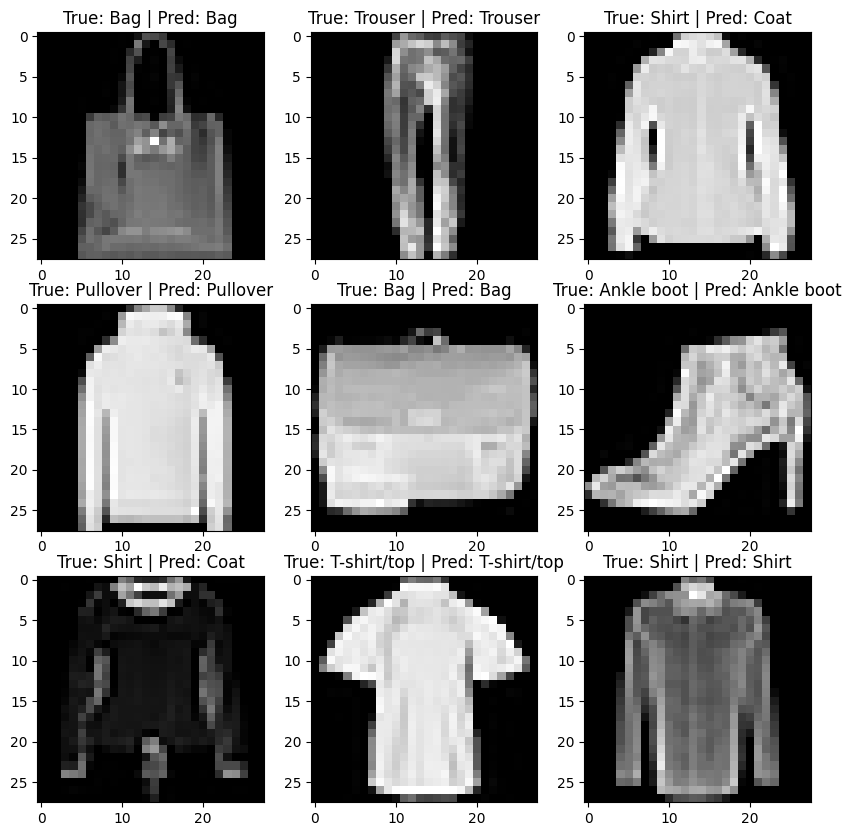

In [49]:

import matplotlib.pyplot as plt
import random

# Select random 9 predictions
random_selection = random.sample(range(len(test_preds)), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
    # Get true and predicted labels
    true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
    pred_label = fashion_mnist_class_names[test_preds[idx]]

    # Plot the prediction with its true label
    plt.subplot(3, 3, i+1)
    plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
    plt.title(f"True: {true_label} | Pred: {pred_label}")


plt.show()